____
__Universidad Tecnologica Nacional Buenos Aires__<br/>
__Ingenieria Industrial__<br/>
__Ciencia de Datos - Curso I5521 - Turno Sabado Mañana__<br/>
__Docente: Martin Palazzo__<br/>
__source: https://github.com/martinepalazzo__<br/>
__Tema: Reduccion de la dimensionalidad__
____

In [ ]:
# liver 1
# renal 0

### Import libraries

In [ ]:
# basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

#sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#tensorflow keras
import keras
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras import models
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

check if we are using GPU or CPU

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8245939644619409265
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 356988128707294688
physical_device_desc: "device: XLA_CPU device"
]


### Import Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving liver_kidney_expseq.csv to liver_kidney_expseq.csv


In [ ]:
#uploaded = files.upload()

In [ ]:
data = pd.read_csv('./liver_kidney_expseq.csv', delimiter = ',', index_col=0 )
print('Shape:', data.shape)
data.head()

Shape: (812, 1027)


,0,?,A1BG,A2M,AADAC,ABP1,ACAA1,ACAA2,ACADVL,ACAT1,ACP5,ACSL1,ACSM2A,ACSM2B,ACTA2,ACTB,ACTG1,ACTN4,ACY1,ADH1A,ADH1B,ADH1C,ADH4,ADI1,ADM,AEBP1,AES,AFP,AGR2,AGT,AGXT,AHSG,AIF1L,AKR1A1,AKR1B1,AKR1B10,AKR1C1,AKR1C2,AKR1C3,AKR1C4,...,TUBB2C,TXN,TXNIP,TYROBP,UBB,UBC,UBD,UBL5,UGT1A1,UGT1A4,UGT1A6,UGT1A9,UGT2B15,UGT2B4,UGT2B7,UMOD,UQCRC1,UQCRC2,UQCRH,UQCRQ,USMG5,VAMP8,VCAM1,VDAC1,VEGFA,VIM,VKORC1,VTN,VTRNA1-1,VWF,WDR74,WFDC2,XAGE1D,XBP1,YBX1,YWHAE,YWHAQ,YWHAZ,ZFP36,ZFP36L1
0,0.0,0.000320,1.205316e-06,0.000870,0.000000e+00,0.000136,0.000062,0.000311,0.000478,0.000138,0.000107,0.000222,0.000364,0.000201,0.000777,0.002539,0.001084,0.000233,0.000070,0.000000e+00,2.826390e-07,0.000000e+00,0.000000e+00,0.000121,0.001066,0.000388,0.000246,8.337533e-08,2.792460e-08,0.000091,2.818430e-07,1.733514e-08,0.000048,0.000219,0.000617,4.698390e-08,0.000262,0.000021,0.000148,1.100184e-07,...,0.000096,0.000374,0.000781,0.000220,0.001093,0.002120,0.000385,0.000357,1.687890e-06,1.326139e-07,0.000035,0.000296,2.370085e-07,0.000000e+00,0.000103,9.593786e-08,0.000100,0.000183,0.000074,0.000074,0.000246,0.000235,0.000411,0.000341,0.002579,0.004286,0.000217,1.720146e-07,0.0,0.000298,0.000036,0.000008,0.000000e+00,0.000081,0.000351,0.000532,0.000179,0.000269,0.000443,0.000245
1,0.0,0.000258,1.041018e-06,0.001258,1.137360e-07,0.000106,0.000051,0.000164,0.000271,0.000136,0.000037,0.000286,0.000167,0.000160,0.001161,0.003779,0.002051,0.000252,0.000048,3.426129e-07,1.215082e-05,4.410115e-07,2.253563e-08,0.000080,0.000208,0.000175,0.000327,9.149890e-08,2.542967e-07,0.000052,1.144449e-06,0.000000e+00,0.000013,0.000149,0.000748,2.005947e-06,0.000029,0.000008,0.000361,4.016505e-08,...,0.000180,0.000374,0.000464,0.000249,0.001031,0.001528,0.000093,0.000328,2.607222e-06,1.033913e-07,0.000164,0.000079,2.068509e-08,0.000000e+00,0.000073,0.000000e+00,0.000108,0.000199,0.000253,0.000070,0.000220,0.000103,0.000212,0.000254,0.001225,0.004354,0.000247,1.626847e-07,0.0,0.000298,0.000029,0.000048,0.000000e+00,0.000182,0.000555,0.000547,0.000277,0.000553,0.000328,0.000312
2,0.0,0.000264,5.559443e-07,0.000696,0.000000e+00,0.000631,0.000066,0.000534,0.000367,0.000244,0.000123,0.000208,0.000232,0.000141,0.000262,0.001977,0.001453,0.000225,0.000104,4.961943e-08,4.468265e-06,6.385555e-08,1.141919e-08,0.000114,0.000374,0.000065,0.000261,0.000000e+00,0.000000e+00,0.000180,6.049459e-07,4.819312e-08,0.000020,0.000281,0.000089,0.000000e+00,0.000141,0.000020,0.000378,2.442844e-07,...,0.000153,0.000776,0.000428,0.000190,0.001627,0.001935,0.000235,0.000346,1.792879e-06,1.265033e-07,0.000254,0.000441,1.048124e-08,0.000000e+00,0.000943,2.970525e-08,0.000152,0.000202,0.000315,0.000100,0.000381,0.000390,0.000653,0.000427,0.000727,0.003777,0.000252,1.126681e-06,0.0,0.000206,0.000049,0.000046,0.000000e+00,0.000110,0.000379,0.000645,0.000187,0.000291,0.000113,0.000136
3,0.0,0.000288,1.599123e-06,0.000942,2.499093e-08,0.000087,0.000046,0.000284,0.000283,0.000083,0.000066,0.000189,0.000076,0.000076,0.000372,0.002800,0.001700,0.000242,0.000056,1.280968e-07,6.876787e-06,2.212439e-07,1.587955e-07,0.000117,0.000198,0.000092,0.000325,1.392887e-06,8.867711e-08,0.000073,1.521965e-06,5.565499e-08,0.000042,0.000151,0.000254,5.295259e-04,0.000153,0.000018,0.000281,1.054537e-07,...,0.000113,0.000613,0.000861,0.000233,0.001224,0.001802,0.000417,0.000313,2.388011e-06,3.599584e-07,0.000122,0.000173,1.093908e-07,2.035745e-08,0.000264,0.000000e+00,0.000104,0.000205,0.000088,0.000071,0.000267,0.000252,0.000202,0.000340,0.001565,0.005108,0.000185,9.536935e-08,0.0,0.000515,0.000042,0.000047,5.798708e-07,0.000214,0.000293,0.000500,0.000242,0.000353,0.000165,0.000143
4,0.0,0.000247,2.226037e-06,0.001935,0.000000e+00,0.000249,0.000058,0.000382,0.000224,0.000090,0.000033,0.000178,0.000131,0.000073,0.000552,0.003097,0.001983,0.000370,0.000041,3.047401e-07,1.700954e-05,1.744599e-07,0.000000e+00,0.000124,0.000423,0.000180,0.000357,1.689218e-07,3.518187e-08,0.000016,2.879904e-07,0.000000e+00,0.000027,0.000138,0.000199,1.984058e-0

In [ ]:
x = data.iloc[:, 1:]
y = data.iloc[:,0]

Perform Train-Test split

In [ ]:
xtr00, xte0, ytr0, yte0 = train_test_split(x, y, test_size=0.3, random_state=42)
#ytr = ytr0.sort_values(by = [0])
ytr = ytr0
xtr0 = xtr00.reindex(ytr.index)
ytr = ytr.values
yte = yte0.values
ytr[ytr == 0] = -1
yte[yte == 0] = -1

MinMax Scaler between 0 and 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
xtr = pd.DataFrame(scaler.fit_transform(xtr0.values))
xte = pd.DataFrame(scaler.transform(xte0))

In [ ]:
xtr.shape

(568, 1026)

Text(33.0, 0.5, 'Patients')

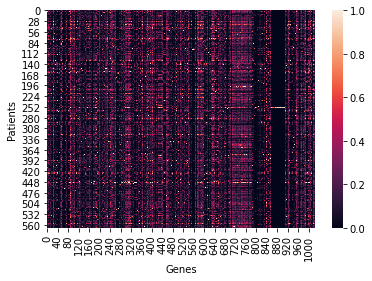

In [ ]:
sns.heatmap(xtr)
plt.xlabel('Genes')
plt.ylabel('Patients')

# **Dimension Reduction**

- PCA
- kPCA
- Autoencoders


We will learn a low dimensional latent space $z$ with different methods

$$
z = f(x)
$$



In [ ]:
latent_dim = 5

## Principal Component Analysis

Implement a PCA of the training data for visualization and exploration. To apply PCA first perform eigen decomposition of the co-variate matrix. Then project the input data by using a projection matrix obtained from the top P eigenvectors associated to the top P eigen values of the eigen decomposition.

$$
\Sigma = \upsilon \lambda \upsilon^{-1} \rightarrow \beta_{dp} \rightarrow \langle X .\beta \rangle = z
$$

In [ ]:
# 
from sklearn.decomposition import PCA
pca = PCA(n_components=latent_dim)
pca.fit(xtr)
ztr_pca = pca.transform(xtr)
zte_pca = pca.transform(xte)

In [ ]:
# check the cumulative variance within the preserved components
np.sum(pca.explained_variance_ratio_)

0.6008211335357879

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


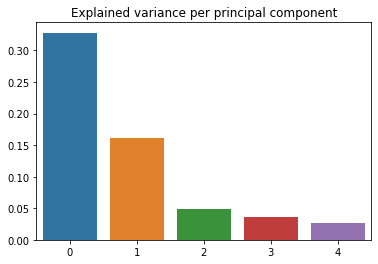

In [ ]:
sns.barplot(np.arange(0,latent_dim),pca.explained_variance_ratio_)
plt.title('Explained variance per principal component')
plt.show()

Text(33.0, 0.5, 'Patients')

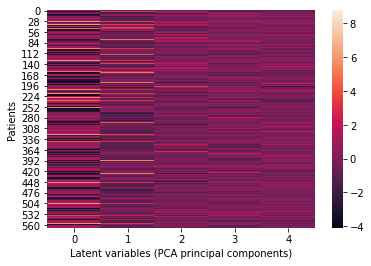

In [ ]:
sns.heatmap(ztr_pca)
plt.xlabel('Latent variables (PCA principal components)')
plt.ylabel('Patients')

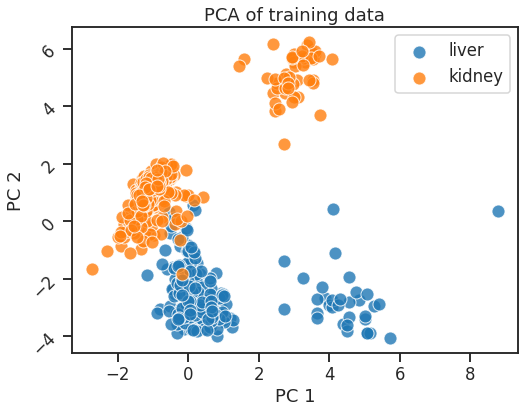

In [ ]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
sns.scatterplot(x=ztr_pca[(ytr == 1).ravel(),1], y=ztr_pca[(ytr == 1).ravel(),0], alpha = 0.8, s= 170, legend='full', label = 'liver')
sns.scatterplot(x=ztr_pca[(ytr == -1).ravel(),1], y=ztr_pca[(ytr == -1).ravel(),0],alpha = 0.8, s= 170, legend='full', label = 'kidney')
ax1.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("PCA of training data")
plt.yticks(rotation=45) 
plt.legend()
plt.show()

# Kernel-PCA

Compute the eigen decomposition of the kernel matrix


$$
K = n U^{-1} \Lambda U \rightarrow Z_{np} = KU^{*}
$$

by using the Gaussian Kernel
$$
k_g(x_i, x_j) = \text{exp}\left ( \frac{\left \| x_i-x_j \right \|^{2}}{2\sigma ^{2}} \right )
$$

which is equivalent to the Radial Basis Function (RBF) Kernel

$$
k_{rbf}(x_i, x_j) = \text{exp}\left (\gamma {\left \| x_i-x_j \right \|^{2}}\right )
$$

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=latent_dim, kernel='rbf',gamma= 0.001)
ztr_kpca = kpca.fit_transform(xtr)
zte_kpca = kpca.transform(xte)

Text(19.499999999999996, 0.5, 'Patients')

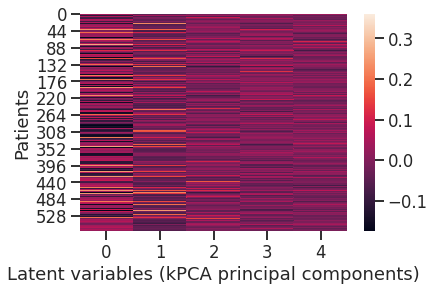

In [ ]:
sns.heatmap(ztr_kpca)
plt.xlabel('Latent variables (kPCA principal components)')
plt.ylabel('Patients')

# Autoencoder
Here an autoencoder function is defined. The architecture can be changed if it is necessary. The Autoencoder is composed by two functions, the encoder

$$
z = f(x)
$$

and the decoder

$$
\hat{x} = q(z)
$$

and the autoencoder model is 

$$
\hat{x} = q(z) = q(f(x))
$$

trained to minimize the mean squared error between the input and reconstructed vectors

$$
L(x , \hat{x}) = L(x , q(f(x))) = \left \| x - \hat{x} \right \|^{2}
$$


In [ ]:
def ae_arch_0(encoding_dim, epochs, bachs, l1_reg, l2_reg, lrate, xtr, xte): 

    'Autoencoder function adapted from the paper'  
    'A pan-cancer somatic mutation embedding using autoencoders.  Palazzo, et. Al. BMC Bioinformatics 20, 655 (2019). https://doi.org/10.1186/s12859-019-3298-z '
    
    earlstop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)
    rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
    
    ################### Optimizer ###################
    optim = keras.optimizers.Adam(lr=lrate)

    ################### MODEL ARCHITECTURE ###############
    
    # 00) INPUT
    inputdim = Input(shape=(xtr.shape[1],))
    
    # 01) DENSE LAYER
    encode_i = Dense(200, kernel_regularizer=regularizers.l2(l2_reg), activation = 'relu')(inputdim)
    
    # 02) BATCH NORM
    bn_i = BatchNormalization()(encode_i)
    
    # 03) DENSE LAYER
    encode_ii = Dense(100, activation = 'relu')(bn_i)

    latent = Dense(encoding_dim, kernel_regularizer = regularizers.l2(l2_reg), activation = 'relu')(encode_ii)

    # 04) DECODER
    #decode_i = Dense(100, activation = 'relu')(latent)
    decode_ii = Dense(200,activation='relu')(latent)
    
    # 05) DECODER
    decode_iii = Dense(xtr.shape[1],activation='linear')(decode_ii)
    
    # 06) AUTOENCODER
    autoencoder = Model(inputdim, decode_iii)
    encoder = Model(inputdim, latent)
    
    #encoded_input5 = Input(shape=(encoding_dim5,))
    #decoder_layer5 = autoencoder5.layers[-3]
    #decoder5 = Model(x3, decoder_layer5(x3))

    autoencoder.summary()
    tf.keras.utils.plot_model(autoencoder, show_shapes=True)
    keras.utils.plot_model(autoencoder, show_shapes=True)
    compression_factor = float(np.shape(xtr)[1]) / encoding_dim
    print("Compression factor: %s" % compression_factor)
    
    ################## COMPILE AND FIT MODEL #############
    autoencoder.compile(optimizer=optim, loss='mse')
    autoencoder.fit(xtr, xtr,epochs=epochs, batch_size=bachs,  shuffle=True,  validation_data=(xte, xte), callbacks = [earlstop, rlrop])
    
    histval = autoencoder.history.history['val_loss']
    histtra = autoencoder.history.history['loss']
    
    return encoder, histtra, histval

Train an autoencoder model. Store the encoder function and the training loss scores.

In [ ]:
encoder_val, hist_tra, hist_val = ae_arch_0(latent_dim,50,32,0.001, 0.003, 0.0001, xtr, xte)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1026)]            0         
_________________________________________________________________
dense (Dense)                (None, 200)               205400    
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
_________________________________________________________________
dense_3 (Dense)              (None, 200)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 1026)             

Plot the training and validation Loss.

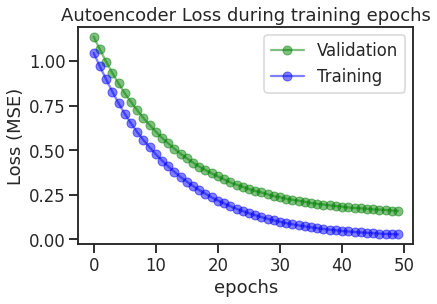

In [ ]:
plt.plot(hist_val, c = 'g', label = "Validation", marker = 'o', alpha = 0.5)
plt.plot(hist_tra, c = 'b', label = "Training", marker = 'o', alpha = 0.5)
plt.title("Autoencoder Loss during training epochs")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss (MSE)')
plt.show()

Encode training and validation samples by using the Encoder function to obtain its projection on the latent space.

In [ ]:
ztr_ae = encoder_val.predict(xtr)
zte_ae = encoder_val.predict(xte)

Visualize the training samples by class (1 or -1) in the latent space.

Text(19.499999999999996, 0.5, 'Patients')

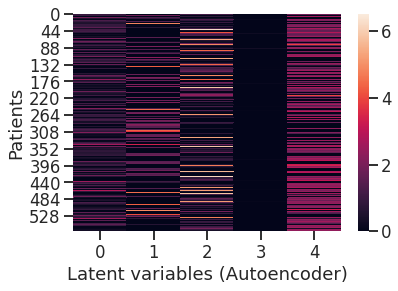

In [ ]:
sns.heatmap(ztr_ae)
plt.xlabel('Latent variables (Autoencoder)')
plt.ylabel('Patients')

# Visualize 

In [ ]:
ztr_ae_tsne = TSNE(n_components=2).fit_transform(ztr_ae)
ztr_kpca_tsne = TSNE(n_components=2).fit_transform(ztr_kpca)
ztr_pca_tsne = TSNE(n_components=2).fit_transform(ztr_pca)

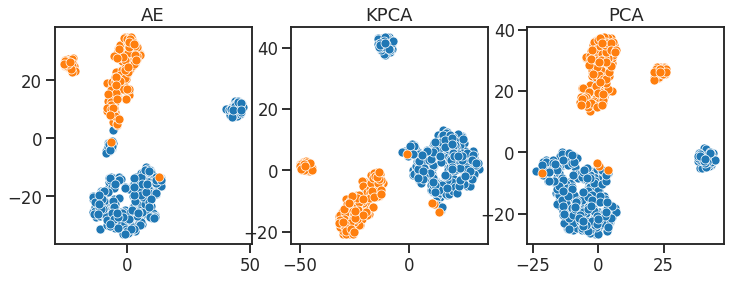

In [ ]:
f, ax = plt.subplots(1,3)
f.set_size_inches(12,4)
sns.scatterplot(x = ztr_ae_tsne[(ytr).ravel() == -1,0], y = ztr_ae_tsne[ytr.ravel() == -1,1], ax= ax[0])
sns.scatterplot(x = ztr_ae_tsne[ytr.ravel() == 1,0], y = ztr_ae_tsne[ytr.ravel() == 1,1], ax= ax[0])
ax[0].set_title("AE")
sns.scatterplot(x = ztr_kpca_tsne[(ytr).ravel() == -1,0], y = ztr_kpca_tsne[ytr.ravel() == -1,1], ax= ax[1])
sns.scatterplot(x = ztr_kpca_tsne[ytr.ravel() == 1,0], y = ztr_kpca_tsne[ytr.ravel() == 1,1], ax= ax[1])
ax[1].set_title("KPCA")
sns.scatterplot(x = ztr_pca_tsne[(ytr).ravel() == -1,0], y = ztr_pca_tsne[ytr.ravel() == -1,1], ax= ax[2])
sns.scatterplot(x = ztr_pca_tsne[ytr.ravel() == 1,0], y = ztr_pca_tsne[ytr.ravel() == 1,1], ax= ax[2])
ax[2].set_title("PCA")
plt.show()

# Clustering using the latent space

Perform clustering on the learned latent space $z$. 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

rand_index_pca = []
rand_index_kpca = []
rand_index_ae = []

# iterate for different number of clusters
for clust in range(2,10):
  kmeans_pca = KMeans(n_clusters=clust, random_state=0).fit(ztr_pca)
  kmeans_kpca = KMeans(n_clusters=clust, random_state=0).fit(ztr_kpca)
  kmeans_ae = KMeans(n_clusters=clust, random_state=0).fit(ztr_ae)

  # measure clustering performance
  rand_index_pca.append(adjusted_rand_score(ytr, kmeans_pca.labels_))
  rand_index_kpca.append(adjusted_rand_score(ytr, kmeans_kpca.labels_))  
  rand_index_ae.append(adjusted_rand_score(ytr, kmeans_ae.labels_))

Text(0.5, 1.0, 'Clustering performance using latent space')

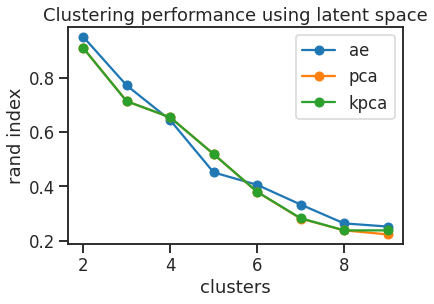

In [ ]:
plt.plot(np.arange(2,10), rand_index_ae, label = 'ae', marker = 'o')
plt.plot(np.arange(2,10), rand_index_pca, label = 'pca', marker = 'o')
plt.plot(np.arange(2,10), rand_index_kpca, label = 'kpca', marker = 'o')
plt.legend()
plt.ylabel('rand index')
plt.xlabel('clusters')
plt.title('Clustering performance using latent space')

In [ ]:
ztr_ae.shape[0]/ztr_ae.shape[1]

113.6

In [ ]:
xtr.shape[0]/xtr.shape[1]

0.5536062378167641